In [1]:
import pandas as pd
import xarray as xr

from argopy import DataFetcher as ArgoDataFetcher
import datetime as dt
from datetime import date

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from global_land_mask import globe

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
#Helper functions

def depth_zone(d: float) -> str:
    """
    Classify the input as one of "Epipelagic", "Mesopelagic", "Bathypelagic"
    
    Input:
        d: float
            depth of sea, between 0 and 2000
    Return:
        zone: str
            one of "Epipelagic", "Mesopelagic", and "Bathypelagic"
    """
    if 0 <= d <= 200:
        return "Epipelagic"
    elif 200 < d <= 1000:
        return "Mesopelagic"
    else:
        return "Bathypelagic"
    
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Fall', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(dat: dt.datetime) -> str:
    """
    Returns the season of a particular date
    
    Input:
        date: datetime
            a date
    Return:
        season: str
    """
    if isinstance(dat, dt.datetime):
        dat = dat.date()
    dat = dat.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= dat <= end)

In [3]:
def fetch_data(start_time: str, end_time: str, attribute: str,
               min_lon: float = -180, max_lon: float = 180, 
               min_lat: float = -90, max_lat: float = 90, 
               min_dep: float = 0, max_dep: float = 2000, ) -> pd.DataFrame:
    """
    Fetch Argo data using the API, with the specified locations, 
    time frame, depth, and attributes.
    
    Inputs:
        start_time, end_time: str, required
            the desired time frame. Should be in format 'yyyy-mm-dd'
        attribute: str, required
            The desired type of attributes from one of 'salinity' or 'temp'.
        min_lon, max_lon: float
            the desired range of longitudes between -180 and 180
        min_lat, max_lat: float
            the desired range of latitudes between -90 and 90
        min_depth, max_depth: float
            the desired depth between 0 and 2000
    
    Return:
        result: pd.DataFrame
            A data frame containing float no., season, location, depth (m), depth zone, 
            temp/salinity
    """
    
    #Check input
    assert -180 <= min_lon <= max_lon <= 180, "Please enter valid min_lon or max_lon" 
    assert -90 <= min_lat <= max_lat <= 90, "Please enter valid min_lat or max_lat" 
    assert 0 <= min_dep <= max_dep <= 2000, "Please enter valid min_dep or max_dep" 
    
    try:
        dt.datetime.strptime(start_time, "%Y-%m-%d")
        dt.datetime.strptime(end_time, "%Y-%m-%d")
    except:
        raise Exception("Please enter a valid start_time or end_time.")
        
    assert attribute in ["salinity", "temp"]
    
    #Fetch data from Argo API and store in xarr as an xarray
    reg = [min_lon, max_lon, min_lat, max_lat, min_dep, max_dep, start_time, end_time]
    # print("Downloading data from Argo...")
    xarr = ArgoDataFetcher().region(reg).to_xarray()
    columns = ["PRES", "PSAL", "TEMP", "LATITUDE", "LONGITUDE", "TIME", "DATA_MODE", \
               "POSITION_QC", "PRES_QC", "PSAL_QC", "TEMP_QC"]
    df = xarr.to_dataframe()[columns]
    
    #TODO: Check there are enough points. How many points should we aim for?
    
    #Subset QC'ed data
    idx = (df['DATA_MODE'] == 'D') & (df['POSITION_QC'] == 1) & \
      (df['PRES_QC'] == 1) & (df['PSAL_QC'] == 1) & (df['TEMP_QC'] == 1)
    df = df[idx]
    df = df.reset_index(drop = True)
    
    #Classify based on depth
    df["Depth Zone"] = df["PRES"].apply(depth_zone)
    
    #Classify based on season
    df["Season"] = df["TIME"].apply(get_season)
    
    #Get the desired attributes
    if attribute == "salinity":
        df = df[["TIME", "PRES", "LATITUDE", "LONGITUDE", "Depth Zone", "Season", "PSAL"]]
    else:
        df = df[["TIME", "PRES", "LATITUDE", "LONGITUDE", "Depth Zone", "Season", "TEMP"]]
    
    return df

In [4]:
def clean_data(data, var = 'TEMP'):
    data = data.loc[data['Depth Zone'] == 'Mesopelagic']
    avg_data = data.groupby(['LATITUDE', 'LONGITUDE'])[var].mean().reset_index()
    X = avg_data[['LATITUDE', 'LONGITUDE']].to_numpy()
    y = avg_data[var].to_numpy()
    return X, y

In [5]:
def get_cartesian(lat=None, lon=None):
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 6371 # radius of the earth
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return x,y,z

# https://gis.stackexchange.com/questions/298619/mercator-map-coordinates-transformation-formula
def mercator(lonlat, R = 6378137.0):
    lon, lat = lonlat[:,0], lonlat[:, 1]
    x = R * np.radians(lon)
    y = R * np.log(
        np.tan((np.pi * 0.25) + (0.5 * np.radians(lat))))
    return np.array((x, y)).T

In [6]:
w = 5
h = 3

# Temperature

In [7]:
lat_span = np.linspace(50, 65, 401)
lon_span = np.linspace(-60, -40, 401)

lat, lon = np.meshgrid(lat_span, lon_span)
pts = np.vstack([lat.ravel(), lon.ravel()]).T
idx = ~globe.is_land(pts[:, 0], pts[:, 1])
pts = pts[idx]
pts_mrc = mercator(pts)

## 1999 - 2005 Gaussian Process

In [8]:
X_old = np.load('../../Data/X_old.npy')
y_old = np.load('../../Data/y_old.npy')

extent = (X_old[:, 1] >= -60) & (X_old[:, 1] <= -40) & (X_old[:, 0] >= 50) & (X_old[:, 0] <= 65)
X_old = X_old[extent]
y_old = y_old[extent]

X_trn_old, X_tst_old, y_trn_old, y_tst_old = train_test_split(X_old, y_old, random_state = 666, test_size = 0.25)

In [9]:
trend_kernel = 1.0 * RBF(length_scale = 10000, length_scale_bounds = (1, 1e10))
irreg_kernel = 1.0 * RationalQuadratic(length_scale=20, alpha=1.0, length_scale_bounds = (1e-5, 1e10))
noise_kernel = 1.0 * RBF(length_scale = 0.1, length_scale_bounds = (1e-5, 10)) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))

kernel = trend_kernel + irreg_kernel + noise_kernel

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr_old = GaussianProcessRegressor(kernel = kernel, random_state = 0, normalize_y = True)
gpr_old.fit(mercator(X_trn_old), y_trn_old) 

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1e+04) + 1**2 * RationalQuadratic(alpha=1, length_scale=20) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         normalize_y=True, random_state=0)

In [11]:
trn_error = np.mean((gpr_old.predict(mercator(X_trn_old)) - y_trn_old)**2)
tst_error = np.mean((gpr_old.predict(mercator(X_tst_old)) - y_tst_old)**2)

print('Train error:\t', trn_error)
print('Test error:\t', tst_error)

Train error:	 0.00021866787430904397
Test error:	 0.10286373336346996


In [12]:
y_hat_old, sds_old = gpr_old.predict(pts_mrc, return_std = True)

## 2018 - 2020 Gaussian Process

In [13]:
X_cur = np.load('../../Data/X_curr.npy')
y_cur = np.load('../../Data/y_curr.npy')

extent = (X_cur[:, 1] >= -60) & (X_cur[:, 1] <= -40) & (X_cur[:, 0] >= 50) & (X_cur[:, 0] <= 65)
X_cur = X_cur[extent]
y_cur = y_cur[extent]

X_trn_cur, X_tst_cur, y_trn_cur, y_tst_cur = train_test_split(X_cur, y_cur, random_state = 666, test_size = 0.25)

In [14]:
trend_kernel = 1.0 * RBF(length_scale = 10000, length_scale_bounds = (1, 1e10))
irreg_kernel = 1.0 * RationalQuadratic(length_scale=20, alpha=1.0, length_scale_bounds = (1e-5, 1e10))
noise_kernel = 1.0 * RBF(length_scale = 0.1, length_scale_bounds = (1e-5, 10)) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))

kernel = trend_kernel + irreg_kernel + noise_kernel

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr_cur = GaussianProcessRegressor(kernel = kernel, random_state = 0, normalize_y = True)
gpr_cur.fit(mercator(X_trn_cur), y_trn_cur) 

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1e+04) + 1**2 * RationalQuadratic(alpha=1, length_scale=20) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         normalize_y=True, random_state=0)

In [16]:
trn_error = np.mean((gpr_cur.predict(mercator(X_trn_cur)) - y_trn_cur)**2)
tst_error = np.mean((gpr_cur.predict(mercator(X_tst_cur)) - y_tst_cur)**2)

print('Train error:\t', trn_error)
print('Test error:\t', tst_error)

Train error:	 9.091347806720262e-05
Test error:	 0.11455347682779723


In [17]:
y_hat_cur, sds_cur = gpr_cur.predict(pts_mrc, return_std = True)

## 2012

In [18]:
X_2012 = np.load('../tmp/X_2012.npy')
y_2012 = np.load('../tmp/y_2012.npy')

extent = (X_2012[:, 1] >= -60) & (X_2012[:, 1] <= -40) & (X_2012[:, 0] >= 50) & (X_2012[:, 0] <= 65)
X_2012 = X_2012[extent]
y_2012 = y_2012[extent]

X_trn_2012, X_tst_2012, y_trn_2012, y_tst_2012 = train_test_split(X_2012, y_2012, random_state = 666, test_size = 0.25)

In [19]:
trend_kernel = 1.0 * RBF(length_scale = 10000, length_scale_bounds = (1, 1e10))
irreg_kernel = 1.0 * RationalQuadratic(length_scale=20, alpha=1.0, length_scale_bounds = (1e-5, 1e10))
noise_kernel = 1.0 * RBF(length_scale = 0.1, length_scale_bounds = (1e-5, 10)) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))

kernel = trend_kernel + irreg_kernel + noise_kernel

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr_2012 = GaussianProcessRegressor(kernel = kernel, random_state = 0, normalize_y = True)
gpr_2012.fit(mercator(X_trn_2012), y_trn_2012) 

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1e+04) + 1**2 * RationalQuadratic(alpha=1, length_scale=20) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         normalize_y=True, random_state=0)

In [21]:
trn_error = np.mean((gpr_2012.predict(mercator(X_trn_2012)) - y_trn_2012)**2)
tst_error = np.mean((gpr_2012.predict(mercator(X_tst_2012)) - y_tst_2012)**2)

print('Train error:\t', trn_error)
print('Test error:\t', tst_error)

Train error:	 0.00029007271626527707
Test error:	 0.30561704672751666


In [22]:
y_hat_2012, sds_2012 = gpr_2012.predict(pts_mrc, return_std = True)

### Plots

In [23]:
vmin_old = min(y_hat_old)
vmin_cur = min(y_hat_cur)

vmax_old = max(y_hat_old)
vmax_cur = max(y_hat_cur)

vmin = min(vmin_old, vmin_cur)
vmax = max(vmax_old, vmax_cur)

In [24]:
vmin_old = min(2*sds_old)
vmin_cur = min(2*sds_cur)

vmax_old = max(2*sds_old)
vmax_cur = max(2*sds_cur)

vmin_sds = min(vmin_old, vmin_cur)
vmax_sds = max(vmax_old, vmax_cur)

#### 1999 - 2005

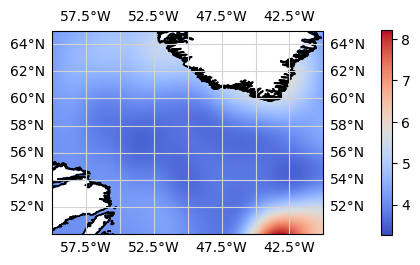

In [25]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = y_hat_old, s = 1, cmap = 'coolwarm', 
                transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='coolwarm', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('old_tmp_contour.png', transparent = True, bbox_inches = 'tight', dpi = 300)

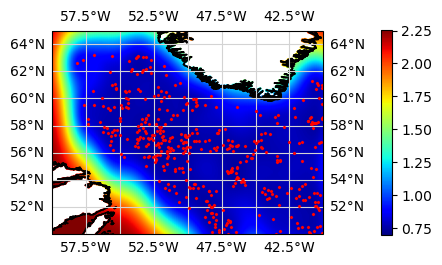

In [26]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = 2*sds_old, s = 1, cmap = 'jet', 
                transform = ccrs.PlateCarree(), vmin = vmin_sds, vmax = vmax_sds)
ax.scatter(X_trn_old[:, 1], X_trn_old[:, 0], c = 'r', marker = 'x', s = 2, zorder = 4)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='jet', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('old_tmp_contour_ci.png', transparent = True, bbox_inches = 'tight', dpi = 300)

#### 2018 - 2020

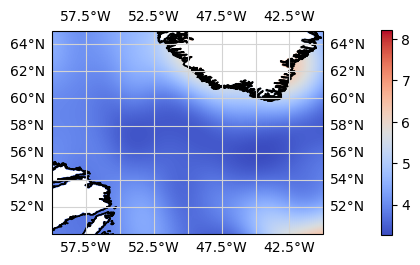

In [27]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = y_hat_cur, s = 1, cmap = 'coolwarm', 
                transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='coolwarm', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('cur_tmp_contour.png', transparent = True, bbox_inches = 'tight', dpi = 300)

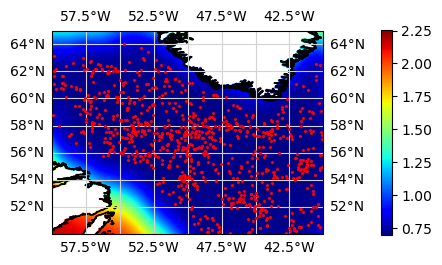

In [28]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = 2*sds_cur, s = 1, cmap = 'jet', 
                transform = ccrs.PlateCarree(), vmin = vmin_sds, vmax = vmax_sds)
ax.scatter(X_trn_cur[:, 1], X_trn_cur[:, 0], c = 'r', marker = 'x', s = 2, zorder = 4)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='jet', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('cur_tmp_contour_ci.png', transparent = True, bbox_inches = 'tight', dpi = 300)

#### 2012

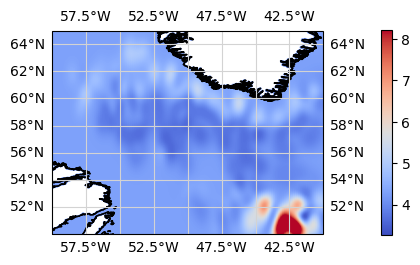

In [29]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = y_hat_2012, s = 1, cmap = 'coolwarm', 
                transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='coolwarm', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('2012_tmp_contour.png', transparent = True, bbox_inches = 'tight', dpi = 300)

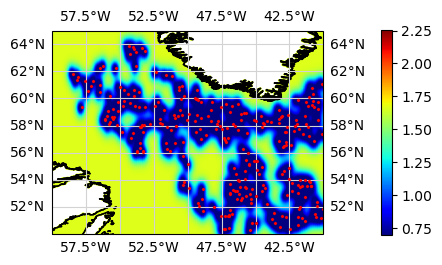

In [30]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = 2*sds_2012, s = 1, cmap = 'jet', 
                transform = ccrs.PlateCarree(), vmin = vmin_sds, vmax = vmax_sds)
ax.scatter(X_trn_2012[:, 1], X_trn_2012[:, 0], c = 'r', marker = 'x', s = 2, zorder = 4)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='jet', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('2012_tmp_contour_ci.png', transparent = True, bbox_inches = 'tight', dpi = 300)

## Difference of Current and Old

In [31]:
dif = y_hat_cur - y_hat_old
sds_dif = (sds_cur**2 + sds_old**2)**0.5

t = max(abs(min(dif)), abs(max(dif)))

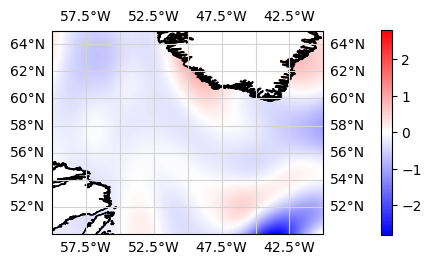

In [32]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = dif, s = 1, cmap = 'bwr', 
                transform = ccrs.PlateCarree(), vmin = -t, vmax = t)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='jet', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('tmp_dif_contour.png', transparent = True, bbox_inches = 'tight', dpi = 300)

In [33]:
zero_idx = (0 < dif - 2*sds_dif) | (0 > dif + 2*sds_dif)

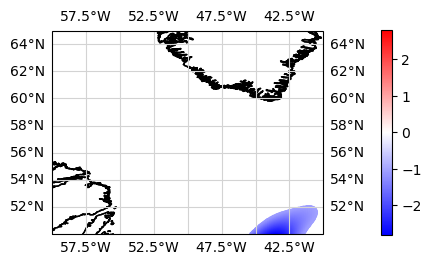

In [34]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1][zero_idx], pts[:, 0][zero_idx], c = dif[zero_idx], s = 1, cmap = 'bwr', 
                transform = ccrs.PlateCarree(), vmin = -t, vmax = t)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='jet', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('tmp_dif_zero.png', transparent = True, bbox_inches = 'tight', dpi = 300)

# Salinity

In [35]:
lat_span = np.linspace(50, 65, 401)
lon_span = np.linspace(-60, -40, 401)

lat, lon = np.meshgrid(lat_span, lon_span)
pts = np.vstack([lat.ravel(), lon.ravel()]).T
idx = ~globe.is_land(pts[:, 0], pts[:, 1])
pts = pts[idx]
pts_mrc = mercator(pts)

## 1999 - 2005 Gaussian Process

In [36]:
X_old = np.load('../sal/X_old.npy')
y_old = np.load('../sal/y_old.npy')

extent = (X_old[:, 1] >= -60) & (X_old[:, 1] <= -40) & (X_old[:, 0] >= 50) & (X_old[:, 0] <= 65)
X_old = X_old[extent]
y_old = y_old[extent]

X_trn_old, X_tst_old, y_trn_old, y_tst_old = train_test_split(X_old, y_old, random_state = 666, test_size = 0.25)

In [37]:
trend_kernel = 1.0 * RBF(length_scale = 10000, length_scale_bounds = (1, 1e10))
irreg_kernel = 1.0 * RationalQuadratic(length_scale=20, alpha=1.0, length_scale_bounds = (1e-5, 1e10))
noise_kernel = 1.0 * RBF(length_scale = 0.1, length_scale_bounds = (1e-5, 10)) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))

kernel = trend_kernel + irreg_kernel + noise_kernel

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr_old = GaussianProcessRegressor(kernel = kernel, random_state = 0, normalize_y = True)
gpr_old.fit(mercator(X_trn_old), y_trn_old) 

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1e+04) + 1**2 * RationalQuadratic(alpha=1, length_scale=20) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         normalize_y=True, random_state=0)

In [39]:
trn_error = np.mean((gpr_old.predict(mercator(X_trn_old)) - y_trn_old)**2)
tst_error = np.mean((gpr_old.predict(mercator(X_tst_old)) - y_tst_old)**2)

print('Train error:\t', trn_error)
print('Test error:\t', tst_error)

Train error:	 9.44781681680633e-07
Test error:	 0.00043616893552005044


In [40]:
y_hat_old, sds_old = gpr_old.predict(pts_mrc, return_std = True)

## 2018 - 2020 Gaussian Process

In [41]:
X_cur = np.load('../sal/X_cur.npy')
y_cur = np.load('../sal/y_cur.npy')

extent = (X_cur[:, 1] >= -60) & (X_cur[:, 1] <= -40) & (X_cur[:, 0] >= 50) & (X_cur[:, 0] <= 65)
X_cur = X_cur[extent]
y_cur = y_cur[extent]

X_trn_cur, X_tst_cur, y_trn_cur, y_tst_cur = train_test_split(X_cur, y_cur, random_state = 666, test_size = 0.25)

In [42]:
trend_kernel = 1.0 * RBF(length_scale = 10000, length_scale_bounds = (1, 1e10))
irreg_kernel = 1.0 * RationalQuadratic(length_scale=20, alpha=1.0, length_scale_bounds = (1e-5, 1e10))
noise_kernel = 1.0 * RBF(length_scale = 0.1, length_scale_bounds = (1e-5, 10)) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))

kernel = trend_kernel + irreg_kernel + noise_kernel

In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr_cur = GaussianProcessRegressor(kernel = kernel, random_state = 0, normalize_y = True)
gpr_cur.fit(mercator(X_trn_cur), y_trn_cur) 

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1e+04) + 1**2 * RationalQuadratic(alpha=1, length_scale=20) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         normalize_y=True, random_state=0)

In [44]:
trn_error = np.mean((gpr_cur.predict(mercator(X_trn_cur)) - y_trn_cur)**2)
tst_error = np.mean((gpr_cur.predict(mercator(X_tst_cur)) - y_tst_cur)**2)

print('Train error:\t', trn_error)
print('Test error:\t', tst_error)

Train error:	 1.4313583469468208e-07
Test error:	 0.0007531648298422853


In [45]:
y_hat_cur, sds_cur = gpr_cur.predict(pts_mrc, return_std = True)

## 2012

In [46]:
X_2012 = np.load('../sal/X_2012.npy')
y_2012 = np.load('../sal/y_2012.npy')

extent = (X_2012[:, 1] >= -60) & (X_2012[:, 1] <= -40) & (X_2012[:, 0] >= 50) & (X_2012[:, 0] <= 65)
X_2012 = X_2012[extent]
y_2012 = y_2012[extent]

X_trn_2012, X_tst_2012, y_trn_2012, y_tst_2012 = train_test_split(X_2012, y_2012, random_state = 666, test_size = 0.25)

In [47]:
trend_kernel = 1.0 * RBF(length_scale = 10000, length_scale_bounds = (1, 1e10))
irreg_kernel = 1.0 * RationalQuadratic(length_scale=20, alpha=1.0, length_scale_bounds = (1e-5, 1e10))
noise_kernel = 1.0 * RBF(length_scale = 0.1, length_scale_bounds = (1e-5, 10)) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))

kernel = trend_kernel + irreg_kernel + noise_kernel

In [48]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr_2012 = GaussianProcessRegressor(kernel = kernel, random_state = 0, normalize_y = True)
gpr_2012.fit(mercator(X_trn_2012), y_trn_2012) 

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1e+04) + 1**2 * RationalQuadratic(alpha=1, length_scale=20) + 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         normalize_y=True, random_state=0)

In [49]:
trn_error = np.mean((gpr_2012.predict(mercator(X_trn_2012)) - y_trn_2012)**2)
tst_error = np.mean((gpr_2012.predict(mercator(X_tst_2012)) - y_tst_2012)**2)

print('Train error:\t', trn_error)
print('Test error:\t', tst_error)

Train error:	 9.11387463709767e-07
Test error:	 0.0016283852425952037


In [50]:
y_hat_2012, sds_2012 = gpr_2012.predict(pts_mrc, return_std = True)

### Plots

In [51]:
vmin_old = min(y_hat_old)
vmin_cur = min(y_hat_cur)

vmax_old = max(y_hat_old)
vmax_cur = max(y_hat_cur)

vmin = min(vmin_old, vmin_cur)
vmax = max(vmax_old, vmax_cur)

In [52]:
vmin_old = min(2*sds_old)
vmin_cur = min(2*sds_cur)

vmax_old = max(2*sds_old)
vmax_cur = max(2*sds_cur)

vmin_sds = min(vmin_old, vmin_cur)
vmax_sds = max(vmax_old, vmax_cur)

#### 1999 - 2005

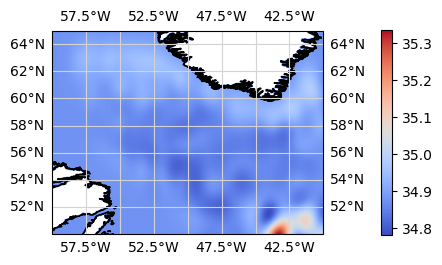

In [53]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = y_hat_old, s = 1, cmap = 'coolwarm', 
                transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='coolwarm', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('old_sal_contour.png', transparent = True, bbox_inches = 'tight', dpi = 300)

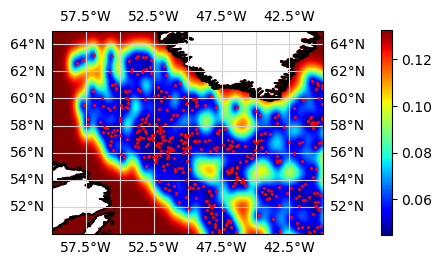

In [54]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = 2*sds_old, s = 1, cmap = 'jet', 
                transform = ccrs.PlateCarree(), vmin = vmin_sds, vmax = vmax_sds)
ax.scatter(X_trn_old[:, 1], X_trn_old[:, 0], c = 'r', marker = 'x', s = 2, zorder = 4)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='jet', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('old_sal_contour_ci.png', transparent = True, bbox_inches = 'tight', dpi = 300)

#### 2018 - 2020

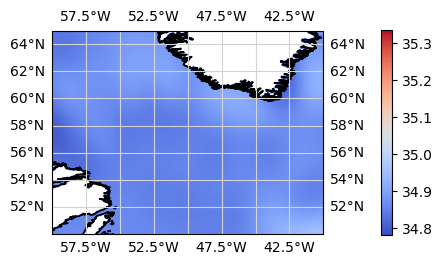

In [55]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = y_hat_cur, s = 1, cmap = 'coolwarm', 
                transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='coolwarm', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('cur_sal_contour.png', transparent = True, bbox_inches = 'tight', dpi = 300)

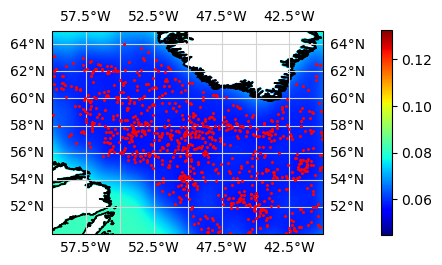

In [56]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = 2*sds_cur, s = 1, cmap = 'jet', 
                transform = ccrs.PlateCarree(), vmin = vmin_sds, vmax = vmax_sds)
ax.scatter(X_trn_cur[:, 1], X_trn_cur[:, 0], c = 'r', marker = 'x', s = 2, zorder = 4)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='jet', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('cur_sal_contour_ci.png', transparent = True, bbox_inches = 'tight', dpi = 300)

#### 2012

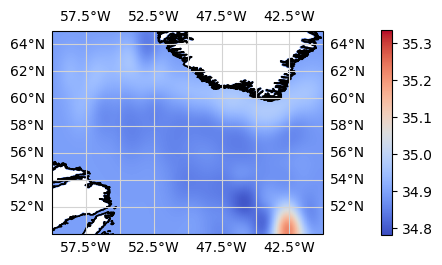

In [57]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = y_hat_2012, s = 1, cmap = 'coolwarm', 
                transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='coolwarm', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('2012_sal_contour.png', transparent = True, bbox_inches = 'tight', dpi = 300)

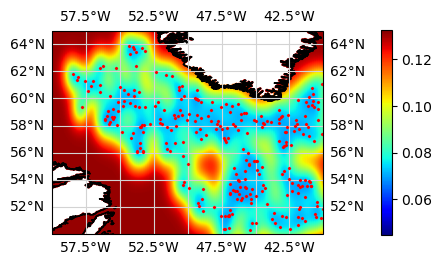

In [58]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = 2*sds_2012, s = 1, cmap = 'jet', 
                transform = ccrs.PlateCarree(), vmin = vmin_sds, vmax = vmax_sds)
ax.scatter(X_trn_2012[:, 1], X_trn_2012[:, 0], c = 'r', marker = 'x', s = 2, zorder = 4)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='jet', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('2012_sal_contour_ci.png', transparent = True, bbox_inches = 'tight', dpi = 300)

## Difference of Current and Old

In [59]:
dif = y_hat_cur - y_hat_old
sds_dif = (sds_cur**2 + sds_old**2)**0.5

t = max(abs(min(dif)), abs(max(dif)))

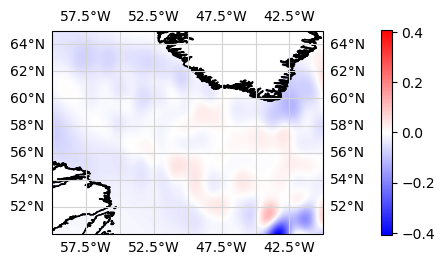

In [60]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1], pts[:, 0], c = dif, s = 1, cmap = 'bwr', 
                transform = ccrs.PlateCarree(), vmin = -t, vmax = t)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='jet', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('sal_dif_contour.png', transparent = True, bbox_inches = 'tight', dpi = 300)

In [61]:
zero_idx = (0 < dif - 2*sds_dif) | (0 > dif + 2*sds_dif)

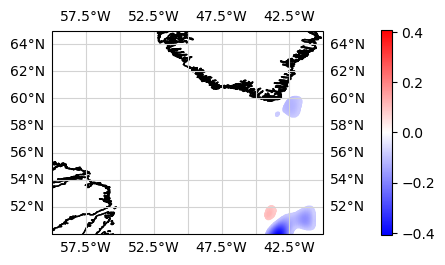

In [62]:
fig = plt.figure(figsize = (w, h))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.coastlines(resolution = 'auto', color = 'k')
ax.gridlines(color = 'lightgrey', linestyle = '-', draw_labels = True)
ax.coastlines()

ct = ax.scatter(pts[:, 1][zero_idx], pts[:, 0][zero_idx], c = dif[zero_idx], s = 1, cmap = 'bwr', 
                transform = ccrs.PlateCarree(), vmin = -t, vmax = t)
ax.set_extent([-60, -40, 50, 65], crs=ccrs.PlateCarree())

plt.colorbar(ct, cmap='jet', orientation='vertical', ticklocation='auto', shrink = 0.89, pad = 0.15)
plt.savefig('sal_dif_zero.png', transparent = True, bbox_inches = 'tight', dpi = 300)